In [1]:
from math_verify import parse, verify
import re
import pandas as pd
import torch
import json

In [2]:
df = pd.read_parquet("../../open-math-reasoning/sample_c7_300_results_repeat_16.parquet")
prompt_to_embed = torch.load("../../open-math-reasoning/sample_c7_300_problem_last_hidden_states.pt")
problem_to_all_layer_embed = {key.split("<|im_start|>user\n")[-1].split("<|im_end|>\n<|im_start|>assistant\n")[0]: value for key, value in prompt_to_embed.items()}

In [3]:
layer = -1
problem_to_embed = {key: value[layer] for key, value in problem_to_all_layer_embed.items()}

In [4]:
def extract_last_boxed_greedy(text):
    if not text:
        return None

    positions = [m.start() for m in re.finditer(r'\\boxed\{', text)]
    if not positions:
        return None

    last_pos = positions[-1]
    rest_of_text = text[last_pos:]
    match = re.match(r'\\boxed\{((?:[^{}]|\{[^{}]*\})*)\}', rest_of_text)
    if match:
        return match.group(1)

    return None

In [5]:
problem_to_pass_rate = {}
for problem in df.problem.unique():
    df_problem = df[df.problem == problem]
    gold = parse(df_problem.expected_answer.tolist()[0])
    num_pass = 0
    num_total = 0
    for response in df_problem.response:
        num_total += 1
        if verify(gold, parse(extract_last_boxed_greedy(response))):
            num_pass += 1
    problem_to_pass_rate[problem] = num_pass / num_total

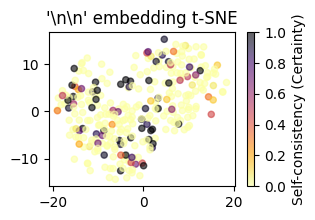

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 模拟一些数据
X = torch.stack([problem_to_embed[problem] for problem in problem_to_pass_rate.keys()])
y = torch.tensor([problem_to_pass_rate[problem] for problem in problem_to_pass_rate.keys()])

# t-SNE 降维
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=666, max_iter=3000)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(3, 2))
plt.tight_layout(pad=0)
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='inferno_r', s=20, alpha=0.6)
plt.colorbar(sc, label="Self-consistency (Certainty)")
plt.title("'\\n\\n' embedding t-SNE")
# remove tick labels
plt.show()

In [25]:
problem_to_embed["Find a basis for the space of polynomials \\( p(x) \\) of degree less than or equal to 3."].shape

torch.Size([4096])

In [11]:
X.shape

torch.Size([298, 4096])

In [26]:
zero_pass_list = [key for key, value in problem_to_pass_rate.items() if value == 0]

In [29]:
df[df.problem == zero_pass_list[1]]

,expected_answer,problem_type,problem_source,generation_model,pass_rate_72b_tir,problem,generated_solution,inference_mode,used_in_kaggle,response,sample_idx
16,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a symmetric matrix $ A $ of size ...,0
17,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are asked to compute the **determinant** of...,1
18,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a **symmetric tridiagonal matrix*...,2
19,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a symmetric matrix $ A $ of size ...,3
20,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are asked to compute the **determinant** of...,4
21,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a **symmetric tridiagonal matrix*...,5
22,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a symmetric matrix of size $ (n+1...,6
23,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are asked to compute the **determinant** of...,7
24,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a symmetric matrix of size $(n+1)...,8
25,\((-1)^n \cdot n \cdot 2^{n-1}\),has_answer_extracted,aops_c7_college_math,DeepSeek-R1,0.25,Calculate the determinant of the matrix \(\beg...,"<think>\nAlright, let's see. I have to find th...",cot,True,We are given a square matrix of size $ n+1 \ti...,9


In [36]:
for i in range(16, 26):
    print(extract_last_boxed_greedy(df[df.problem == zero_pass_list[1]].response[i]))

(-1)^{n(n+1)/2} \cdot (n+1)^{n-1}
(-1)^n \cdot n!
\det(A) = (-1)^n \cdot 2^n
(-1)^n \cdot n \cdot 2^n
(-1)^{n(n+1)/2}
(-1)^n \cdot n!
(-1)^n \cdot n!
(-1)^n \cdot 2^n \cdot n!
(-1)^n \cdot n!
(-1)^n \cdot 2^n
